<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Fabrice Jimenez | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

# Anomaly Detection - Practical Follow-up

This notebook is following the progression of the Anomaly Detection class. It provides practical illustrations in Python and short exercises to understand the notions we have seen in this course.

<div class="alert alert-warning">
Author: Fabrice JIMENEZ
    
Link to course materials: https://github.com/SupaeroDataScience/machine-learning/tree/main/13%20-%20Anomaly%20Detection
</div>

## Preliminary loading with Google Colab

If you are using this notebook with Google Colab, please execute first the following cells, to retrieve the GitHub repository content. Otherwise, ignore these cells and move to the next section.

In [38]:
import os
os.mkdir('data')

FileExistsError: [Errno 17] File exists: 'data'

In [ ]:
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X1.npy?raw=true -O data/X1.npy
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X1_1.npy?raw=true -O data/X1_1.npy
!wget -c https://github.com/SupaeroDataScience/machine-learning/blob/main/13%20-%20Anomaly%20Detection/data/X2.npy?raw=true -O data/X2.npy

## Imports and Loading Dataset

The dataset is sampled from random gaussian distributions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

In [ ]:
X1 = np.load('data/X1.npy')
X1_1 = np.load('data/X1_1.npy') # Variable X1 with far outlier
X2 = np.load('data/X2.npy')
df = pd.DataFrame()
df['X1'] = X1
df['X1_1'] = X1_1
df['X2'] = X2

In [39]:
df.head()

,X1,X1_1,X2
0,12.662034,12.662034,-6.607371
1,-9.890820,-9.890820,4.638357
2,-7.646777,-7.646777,4.984616
3,-4.753542,-4.753542,-2.287770
4,8.975483,8.975483,7.568073


## Useful Functions

Don't worry about these functions at the moment, they will be used later to plot some results.

In [40]:
def plotAnomalies1D(s, anomalies, threshold1, threshold2):
    """
        s: Pandas Series containing all the points to plot
        anomalies: Pandas Series containing all the points which are anomalies
        threshold1: Float value - minimum threshold to be normal
        threshold2: Float value - maximum threshold to be normal
    """
    plt.figure()
    plt.plot(s, [0]*len(s), 'bo')
    plt.plot(anomalies, [0]*len(anomalies), 'ro')
    plt.plot([threshold1]*2, [-1,1], 'g--')
    plt.plot([threshold2]*2, [-1,1], 'g--')

In [41]:
def plotAnomalies2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    plt.figure()
    plt.plot(df['X1'],df['X2'], 'o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([df['X1'].min()-3,df['X1'].max()+3])
    plt.ylim([df['X2'].min()-3,df['X2'].max()+3])
    plt.title(clf_name)
    
    if clf_name == 'LOF':
        ypred = clf.fit_predict(df[['X1','X2']])
        plt.plot(df['X1'][ypred==-1],df['X2'][ypred==-1],'ro')
    else:
        xx, yy = np.meshgrid(np.linspace(df['X1'].min()-3,df['X1'].max()+3, 500), np.linspace(df['X2'].min()-3,df['X2'].max()+3, 500))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')

In [42]:
def plotAnomalyScore2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    if clf_name == 'LOF':
        score = clf.negative_outlier_factor_
    else:
        score = clf.decision_function(df[['X1','X2']])
    
    plt.figure()
    sc = plt.scatter(x=df['X1'],y=df['X2'], c=-score, cmap='Reds')
    plt.colorbar(sc, label='anomaly score')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(clf_name)

## Univariate Outlier Detection

In this section, let's consider a single variable x = X1. Let's visualize the dataset in different ways...

In [43]:
x = 'X1'

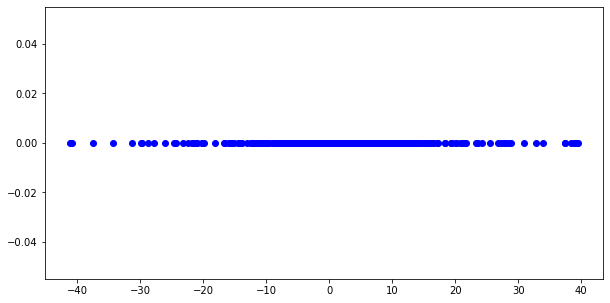

In [44]:
# Scatter plot
plt.figure()
plt.plot(df[x], [0]*len(df), 'bo')

<AxesSubplot:>

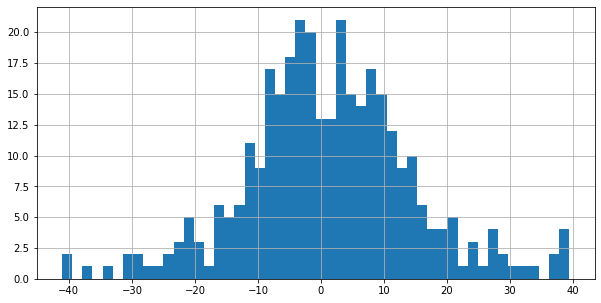

In [45]:
# Histogram
df[x].hist(bins=50)

In [46]:
# Key statistical indicators
df[x].describe()

count    330.000000
mean       1.119313
std       13.497184
min      -41.112042
25%       -6.482452
50%        0.676623
75%        8.979254
max       39.395503
Name: X1, dtype: float64

<div class="alert alert-success">
Question 1: if you had to detect outliers in this 1D dataset, how would you do?
</div>

Implement your own 1D outlier detection method. To do this, you need to compute:
- <em>threshold1</em> : Float value - minimum threshold to be normal
- <em>threshold2</em> : Float value - maximum threshold to be normal
- <em>anomalies</em> : Pandas Series containing all the points which are anomalies

In [47]:
## Using Mean & std
mu = df[x].mean()
sig = df[x].std()

threshold1 = mu - 2*sig
threshold2 = mu + 2*sig
anomalies = df[x][(df[x] - mu).abs() > 2*sig].copy()

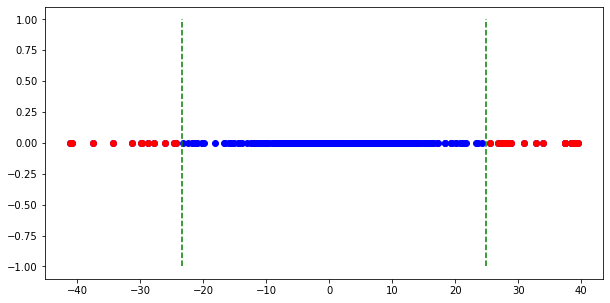

In [48]:
plotAnomalies1D(df[x], anomalies, threshold1, threshold2)

<div class="alert alert-success">
Question 2: What is the impact of far outliers on the method(s) you used?
</div>

<div class="alert alert-warning">

Des outliers très éloignés modifient la moyenne et l'écart type ce qui fausse la détection d'outliers
Solution: utilisation du **MAD** (équivalent de l'écarty type pour la médiane) 
- choix des threshold : 2 ou 3 fois la MAD (Madian absolute deviation) de façon arbitraire - il faut une connaissance expert pour faire ce choix!
   
    
$$ MAD = Median\left( \lvert x-Median(x) \rvert \right) $$

Test your method(s) on variable <em>X1_1</em> instead of <em>X1</em> : 1 single point was changed, to become a very large value.

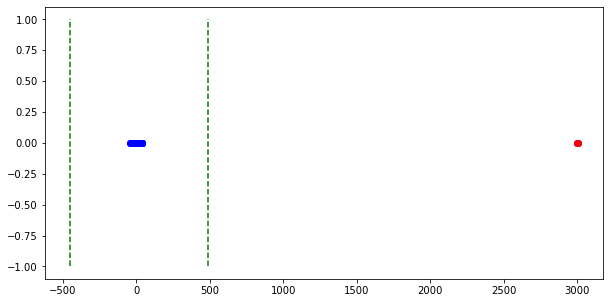

In [49]:
# Testons la détection d'outlier précédente sur X1_1 qui a un outlier très éloigné
x = 'X1_1'

## Using Mean & std
mu = df[x].mean()
sig = df[x].std()

threshold1 = mu - 2*sig
threshold2 = mu + 2*sig
anomalies = df[x][(df[x] - mu).abs() > 2*sig].copy()

plotAnomalies1D(df[x], anomalies, threshold1, threshold2)

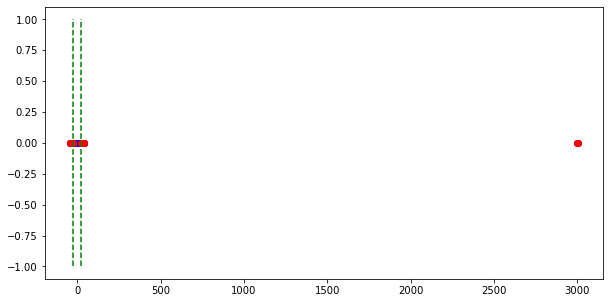

In [53]:
# Testons la détection d'outlier par MAD sur X1_1 qui a un outlier très éloigné

## Using Median and MAD
# MAD : Median absolute deviation = median( abs(x-Median(x)) )
med = df[x].median()
mad = (df[x] - med).abs().median()

threshold1 = med - 3*mad
threshold2 = med + 3*mad
anomalies = df[x][(df[x] - med).abs() > 3*mad].copy()

plotAnomalies1D(df[x], anomalies, threshold1, threshold2)

<div class = "alert alert-warning">

- avec moyenne et écart-type : les threshold sont plus ou moins près selon l'éloignement de l'outlier
- avec MAD, peu importe la distance de l'outlier, on arrive à des bornes fixes
   

## Multivariate Outlier Detection

<div class = "alert alert-warning">

Pour plusieurs variables, on ne peut pas juste utiliser MAD ou écart-type sur chaque variable car celle-ci peuvent être corrélées entre-elles. 
    
Méthodes possibles : 
- **Distance de Mahalanobis $_{AKA}$ Elliptic Envelope** : on peut utiliser la matrice de covariance : distance entre un point et une distribution : $$D (X,M) = \sqrt{(X-\mu)^T \Sigma^{-1}  (X-\mu)}$$
    - c'est une distance "euclidienne" ajustée pour prendre en compte la covariance entre les variables
    - il faut choisir : à partir de quel seuil de distance de Mahalanobis on considère qu'on a une anomalie -> question pour l'expert du phénomène (au cas par cas)
    
    
- **Isolation Forest** : séparer avec des variables (séprer par des hyperplans) et des bornes aléatoires
    - Répéter et faire 100, 1000 arbres
    - en moyenne peu profond dans l'arbre = un point qui se détache facilement de l'arbre (avec peu de coupes) - pour faire cette moyenne (pouvoir comparer des arbres différents, il faut y ajouter une pondération selon la forme de l'arbre)
    - donc mesure de l'anomalité de l'arbre : profondeur moyenne du point sur l'ensemble des arbres
    - il faut décider de à partir de quelle profondeur moyenne on considère que c'est un outlier? 
    - un seul hyperparamètre : le nombre d'arbres sur lesquels on va faire des statistiques de profondeur de point
    - **swamping** : la densité diminue au fur et à mesure qu'on s'éloigne du centre et l'arbre va injustement classer des points en périphérie comme des anomalies
    - **masking** : si on a des anomalies très denses dans un coin, la moyenne des arbres peut déterminer des anomalies comme normales 
        - solution à ces deux problèmes : subsampling
    
    
- **Local outlier factor** : regarder les voisins et leur proximité
    - Pour chaque point A, ono calcule d : la moyenne des distances à ses k plus proches voisins
    - On prend l'inverse de d : 1/d = local reachability density
    - LOF : moyenne(lrd(k-voisins))/lrd(A)
    - LOF <= 1 : low anomaly score
    - LOF > 1 : high anomaly score
    - il faut choisir le seuil pour les valeurs considérées comme normales
    - cette méthode peut détecter comme anormale des points en plein milieu des autres points si elle a une densité locale faible
    
    
- **One class SVM** : exploiter la malédiction de la dimension - en dimension supérieure, il est plus facile de séparer plusieures classes - on veut encercler la majorité de nos données en grande dimension, ce qui permet de bien séparer les points. En dehors de ce cercle, ce sont des anomalies
    - On s'autorise une frontière souple : on décide d'écarter par exemple 5% de nos données qui sont considérées alors comme des anomalies
    - Méthode qui permet de capter des comportements non linéaires 
    - mais très sensible aux seuils et au choix du noyau...

In this section, let's consider 2 variables X1 and X2. Let's visualize the dataset.

Text(0, 0.5, 'X2')

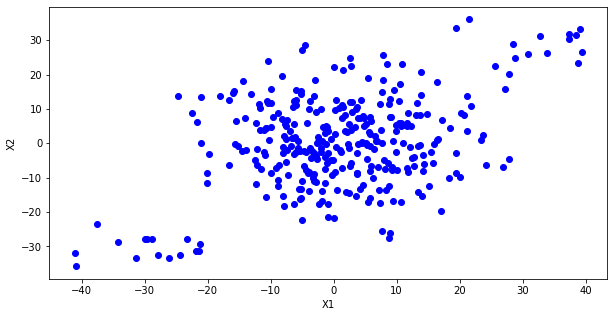

In [54]:
plt.figure()
plt.plot(df['X1'],df['X2'], 'bo')
plt.xlabel('X1')
plt.ylabel('X2')

We will experiment here with the 4 different outlier detection methods we have just seen in class. These methods are directly available in Scikit-Learn.

<div class="alert alert-success">
Question 3: What is the impact of hyperparameters on the detection boundaries / anomalies detected, for each method?
</div>

<b>Question 3.a:</b> For example, compare the behavior of the different models, with contamination rate at same value. What models appear to be easy to tune (without taking into account contamination rate)?

In [66]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

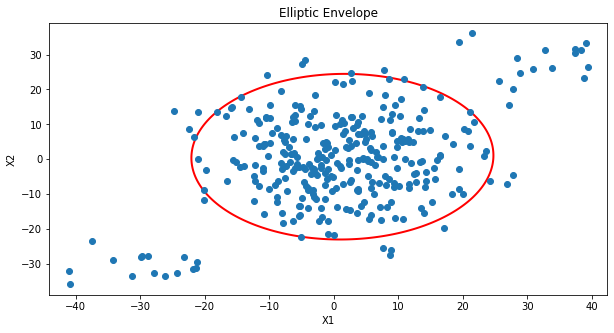

In [70]:
# Elliptic Envelope : aucun hyperparamètre nécessaire
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

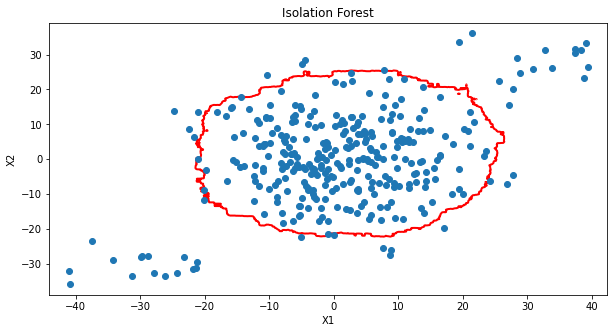

In [78]:
# hyperparamètre : le nombre d'arbre sur lesquels on dera une moyenne de profondeur
n_trees = 100

clf_name = 'Isolation Forest'
clf = IsolationForest(n_estimators=n_trees, contamination=0.15)
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

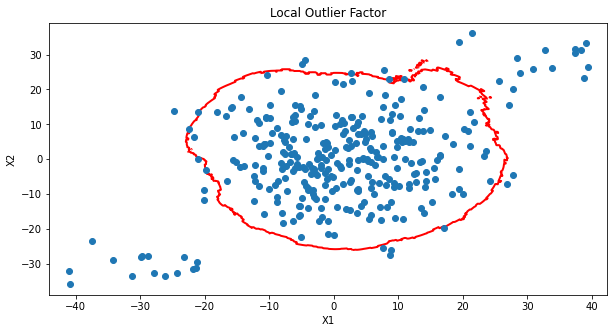

In [95]:
# hyperparamètres : nombre de voisins 
n_neighbors = 35

clf_name = 'Local Outlier Factor'
clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.15, novelty=True) 
#novelty = True : on considère que les 85% de données ne sont pas contaminées!
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

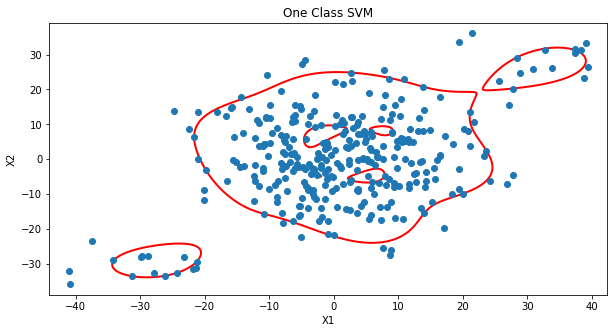

In [100]:
# hyperparamètres : 
noyau = 'rbf'
gamma = 0.005 #coeff du noyau

clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.15, kernel=noyau, gamma=gamma) # nu corresponds to contamination
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

One class SVM est nettement plus difficile à paramétrer que les autres méthodes

<b>Question 3.b:</b> For example, compare the behavior of different contamination rates, with the same model. What difficulties are you facing?

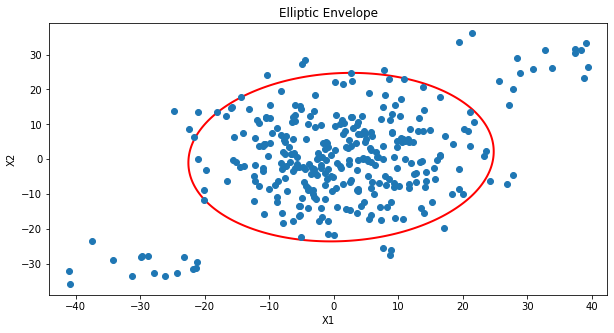

In [62]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

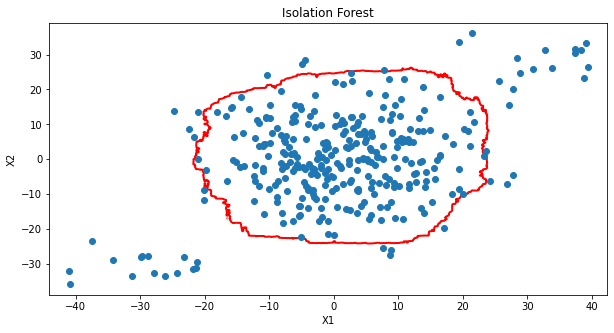

In [63]:
clf_name = 'Isolation Forest'
clf = IsolationForest(n_estimators=100, contamination=0.15)
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

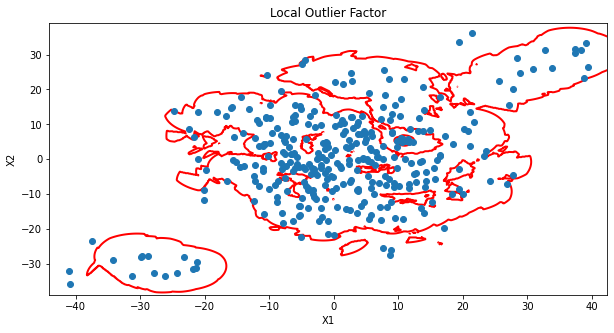

In [64]:
clf_name = 'Local Outlier Factor'
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty=True)
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

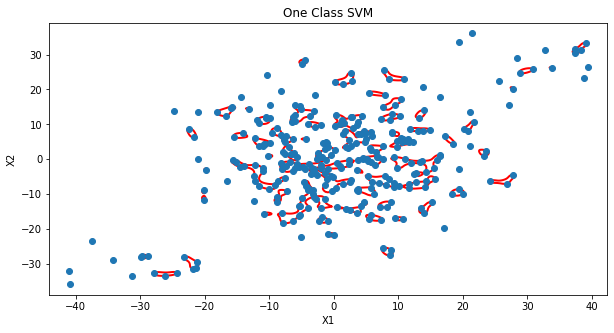

In [65]:
clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3) # nu corresponds to contamination
clf.fit(df[['X1','X2']])
plotAnomalies2D(df, clf_name, clf)

<div class="alert alert-warning">

Trouver les anomalies : le problème est mathématiquement mal défini
- il faut toujours essayer de croiser avec intervention métier/PCA/clustering pour donner un score à l'anomalité des données

<div class="alert alert-success">
Question 4: What alternative do you have instead of tuning the contamination rate?
</div>

Let's compute and visualize, for each model, the continuous anomaly scores.

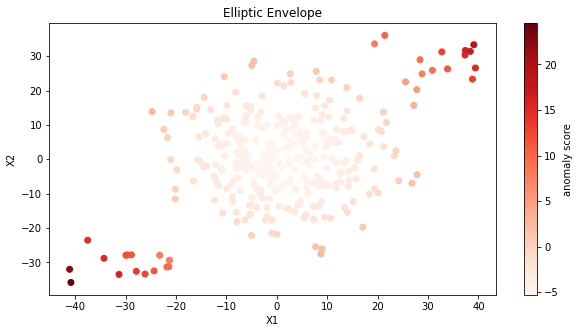

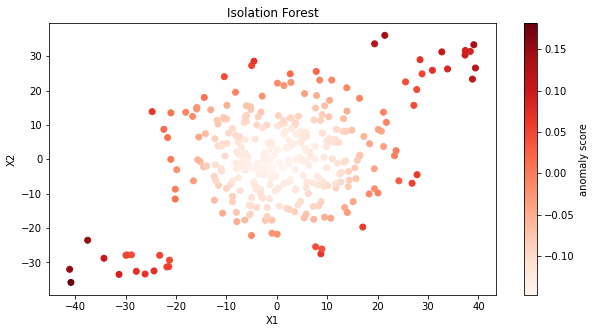

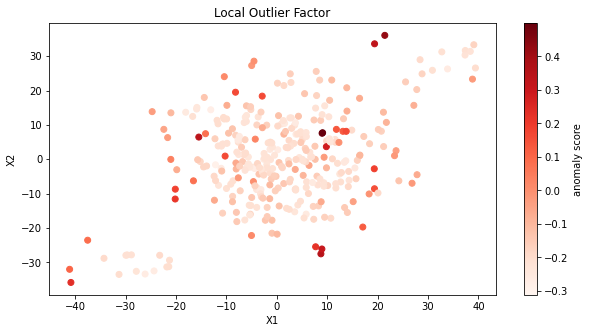

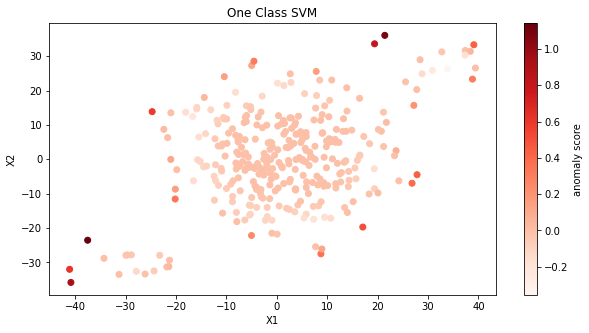

In [110]:
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.15)
clf.fit(df[['X1','X2']])
plotAnomalyScore2D(df, clf_name, clf)

clf_name = 'Isolation Forest'
clf = IsolationForest(n_estimators=100, contamination=0.15)
clf.fit(df[['X1','X2']])
plotAnomalyScore2D(df, clf_name, clf)

clf_name = 'Local Outlier Factor'
clf = LocalOutlierFactor(n_neighbors=5, contamination=0.15, novelty=True)
clf.fit(df[['X1','X2']])
plotAnomalyScore2D(df, clf_name, clf)

clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.15, kernel="rbf", gamma=0.008) # nu corresponds to contamination
clf.fit(df[['X1','X2']])
plotAnomalyScore2D(df, clf_name, clf)



## Novelty Detection

<div class = "alert alert-warning">

Détection d'anomalies qui ne sont pas rares et différentes des autres données

Principe :
- on doit disposer d'un jeu de données clean, sans anomalies 
- donner un score aux nouvelles données pour savoir si elles correspondent ou pas à la distribution que nous avons
- **One Class SVM** est meilleure pour la novelty detection : on peut encercler au plus près (n'importe quelle forme) les données clean
- Possibilité d'utiliser l'**apprentissage supervisé** : 
    - construire des modèles : prédire x3 en fct de x1, x2 || prédire x2 en fct de x1, x3 || prédire x1 en fct de x2, x3
    - si le modèle ne se trompe pas sur la nouvelle donnée : on a probablement un point normal. 
    - si le modèle se trompe sur la nouvelle donnée : la nouvelle donnée est probablement une anomalie 
    - utiliser les "erreurs" des modèles construits sur le dataset clean pour calculer un score d'anormalité

In this section, we split the dataset to have on one side the normal points, and on the other side the new points which are anomalies.

In [101]:
normal_df = df.iloc[:300].copy()
new_anomalies = df.iloc[300:].copy()

Text(0, 0.5, 'X2')

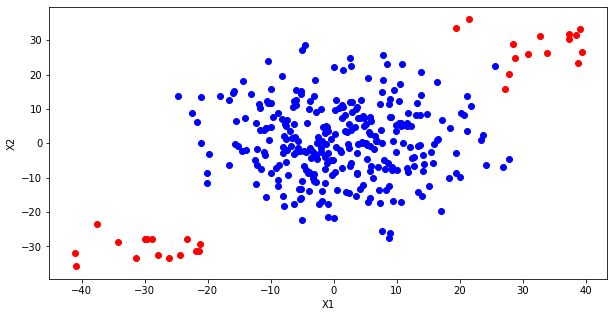

In [102]:
plt.figure()
plt.plot(normal_df['X1'], normal_df['X2'], 'bo')
plt.plot(new_anomalies['X1'], new_anomalies['X2'], 'ro')
plt.xlabel('X1')
plt.ylabel('X2')

The purpose of novelty detection is to learn the behavior of normal points. We can use unsupervised methods such as those we have seen earlier, but we can also use supervised learning.

<div class="alert alert-success">
Question 5: Implement your novelty detection approach using supervised learning, to predict each variable in function of the others.
</div>

To do this, you have to select a supervised model $\tilde{f}$ to learn the relationship between X1 and X2. 

$$
\tilde{X}_2 = \tilde{f}\left(X_1\right)
$$You need to compute:
- <em>ypred_normal</em> : an array containing the predicted values for the normal dataset
- <em>ypred_anomalies</em> : an array containing the predicted values for the new anomalies dataset

In [111]:
X = np.array(normal_df['X1']).reshape(-1,1)
y = np.array(normal_df['X2'])

In [112]:
###### CODE HERE ######
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=200, max_depth=20)
regr.fit(X, y)

ypred_normal = regr.predict(np.array(normal_df['X1']).reshape(-1,1))
ypred_anomalies = regr.predict(np.array(new_anomalies['X1']).reshape(-1,1))
#######################

Let's visualize the superposition of actual values and the predicted values, as scatter plot.

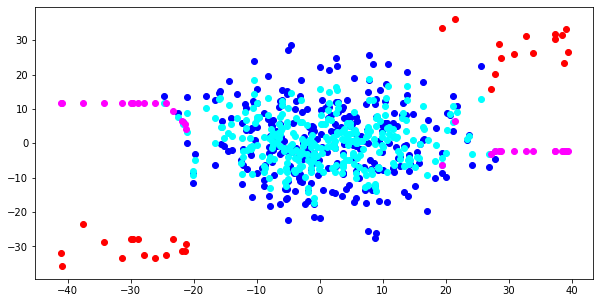

In [113]:
# Superposition
plt.figure()
plt.scatter(x=normal_df['X1'],y=normal_df['X2'],c='b')
plt.scatter(x=normal_df['X1'],y=ypred_normal,c='cyan')

plt.scatter(x=new_anomalies['X1'],y=new_anomalies['X2'],c='r')
plt.scatter(x=new_anomalies['X1'],y=ypred_anomalies,c='magenta')

<div class = "alert alert-warning">
    
- bleu : dataset clean
- bleu clair : prédictions sur les données bleu
- rouge : dataset des anomalies
- rose : prédiction sur les données rouge : grande erreur entre les valeurs réelles et le prédictions 
    - c'est normal : on n'a pas appris sur ces données 

We can also look at the predicted values versus the actual values, for normal and anomaly points.

Text(0, 0.5, 'Predicted values')

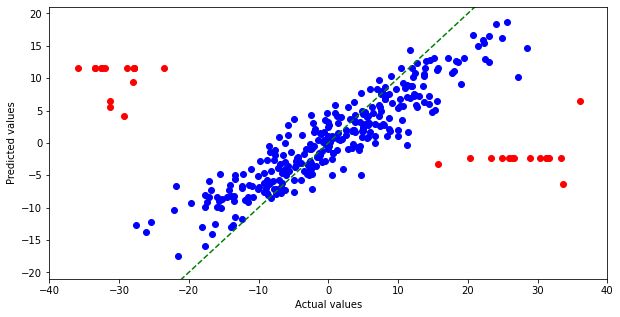

In [114]:
# Value / Value plot
plt.figure()
plt.scatter(x=normal_df['X2'], y=ypred_normal, c='b')
plt.scatter(x=new_anomalies['X2'], y=ypred_anomalies,c='r')
plt.plot([-50,50], [-50,50], 'g--')
plt.xlim([-40,40])
plt.ylim([-21,21])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

<div class="alert alert-success">
Question 6: To compute an anomaly score, we will use the prediction error of the model. Compute for example the mean squared error for normal points and anomaly points.
</div>

In [116]:
###### CODE HERE ######
error_normal = (normal_df['X2'] - ypred_normal)**2
error_anomalies = (new_anomalies['X2'] - ypred_anomalies)**2
#######################

Finally, let's visualize the prediction error as color levels.

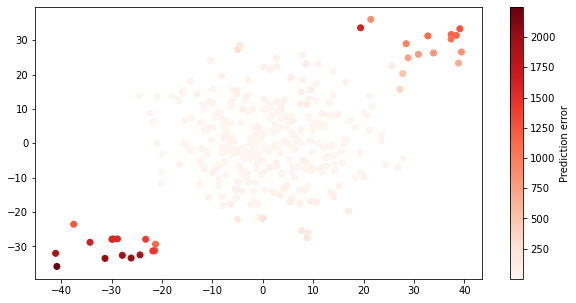

In [117]:
plt.figure()
sc = plt.scatter(x=list(normal_df['X1']) + list(new_anomalies['X1']), 
            y=list(normal_df['X2']) + list(new_anomalies['X2']), 
            c=list(error_normal) + list(error_anomalies),
            cmap='Reds')
plt.colorbar(sc, label='Prediction error')

It looks like a pretty good anomaly score!

<div class = "alert alert-warning">
    
On voit qu'on a bien un score d'anomalie supérieure pour les anomalies : la méthode fonctionne
- la méthode utilisant l'apprentissage supervisé détecte comme anormal tout comportement qui ne correspond pas au comportement des points sur lesquels le modèle a été appris
- Si des points normaux sont détectés comme des anomalies, ça veut dire que le dataset d'apprentissage n'était pas assez complet pour prendre en compte tous les comportements normaux

<div class = "alert alert-success">

# Conclusion : 

**Les étapes de la détection d'anomalies :**
- *1e étape* : définir le problème - c'est quoi une anomalie
- *2e étape* : quel type d'anomalies
    - outlier detection : 4 méthodes non supervisées
    - novelty detection : il faut un jeu de données propres 
        - méthodes non supervisées : One class SVM est meilleure pour la novelty detection que pour l'outlier detection 
        - méthodes supervisées pour apprendre ce qu'est la normalité
- *3e étape* : on a des score d'anomalité continue : il faut l'intervention humaine pour déterminer un seuil 
    - Expert knowledge, PCA, etc. 
    - Validation forte ou faible
        - Validation forte : vérité terrain, on valide sur un jeu de données qu'on sait être la vérité
        - Validation faible : mettre à disposition d'une interface qui permet de tester la méthode et l'opérateur humain analyse si la méthode donne le bon résultat ou non
- *4e étape* : reformuler le problème
    - un modèle plus simple avec moins de variables? 
    - on obtient un seuil simple pour rejeter les anomalies
    - on trouve un modèle de décision facile (peu coûteux) à utiliser par la suite
    
**A garder en tête** : beaucoup d'évolutions rapides dans le ML 
- il faut aller du global au détail : se concentrer sur les problèmes des méthodes qui évoluent peu 
    - Partir de objectifs puis choisir les moyens et enfin la technique : 
        - Objectifs : basé sur les données historiques, détecter quand le comportement est différent
        - Moyens : choisir entre outlier detection et novelty detection 
        - Techniques : random forrest, MSE, etc.